# Regularization


Regularization is a field with lots of ongoing research, so like many other things with deep learning keeping up with the literature matters. That said, we will examine two common tactics for regularlizing neural networks: Dropout and Early Stopping.

## Dropout

Dropout is almost hilariously simple given how well it works: during the training process, randomly throw away the outputs from some percentage of the nodes on a layer-by-layer basis. We change which node's output is thrown away during the training rounds, which forces the network to find multiple possible combinations of nodes that still result in a correct prediction, which makes it less likely that the network has overfit or memorized the training data. 

![image.png](img/dropout.png)

Image from: Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from
overfitting”, JMLR 2014

We do have to be somewhat judicious, dropping too much will simply stop the network from learning during training. Dropping too little won't significantly improve the validation/test results. Anothing thing to keep in mind is that dropout will increase the amount of time a model needs to converge. Normally every node gets an adjustment for each batch during training, now only non-dropped nodes get an adjustment. If our dropout rates are quite large, it will take longer for the model to converge. 

Dropout is easy to implement in Keras, lets take a look:


In [1]:
# Again, this should all look familiar
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

mnist_num_classes = 10 
mnist_image_size = 784

(mnist_training_images, mnist_training_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()
mnist_training_data = mnist_training_images.reshape(mnist_training_images.shape[0], mnist_image_size) 
mnist_test_data = mnist_test_images.reshape(mnist_test_images.shape[0], mnist_image_size)

mnist_training_labels = to_categorical(mnist_training_labels, mnist_num_classes)
mnist_test_labels = to_categorical(mnist_test_labels, mnist_num_classes)

In [2]:
# A helpful function we'll be using all over the place to plot training information:
def plot_training_history(history, model):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.tight_layout()

    figure.tight_layout()
    plt.tight_layout()
    plt.show()
    
    loss, accuracy  = model.evaluate(mnist_test_data, mnist_test_labels, verbose=False)

    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')

In [3]:
# Most of the literature suggests using different dropout rates for the hidden layers and the
# visible (input) layers. Specifically, people rarely use dropout on the input layer, and if 
# you do the rate should be very small. Large (.3-.5) dropout rates on the hidden layers are
# not uncommon. Lets experiment with different choices for each.

# Here, we are using the model that performed pretty well in the previous exercise
# and adding dropout layers after each hidden layer. 
def model_with_dropout(dropout_rate):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(mnist_image_size,)))
    
    for _ in range(5):
        model.add(Dense(units=64, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=mnist_num_classes, activation='softmax'))
    
    return model


dropout_rate: 0.8


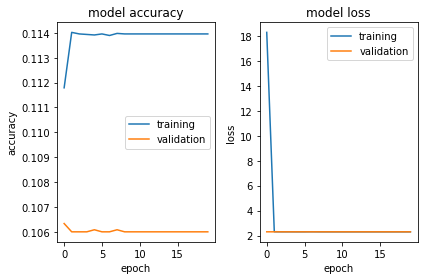

Test loss: 2.3
Test accuracy: 0.113

dropout_rate: 0.5


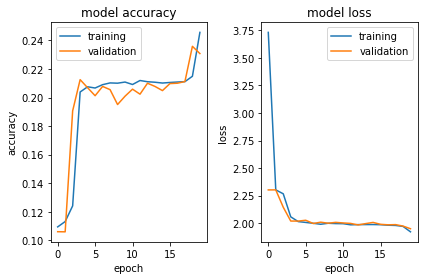

Test loss: 1.95
Test accuracy: 0.24

dropout_rate: 0.3


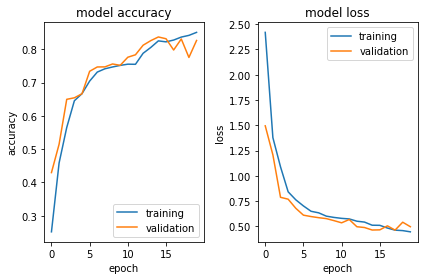

Test loss: 0.525
Test accuracy: 0.822

dropout_rate: 0.2


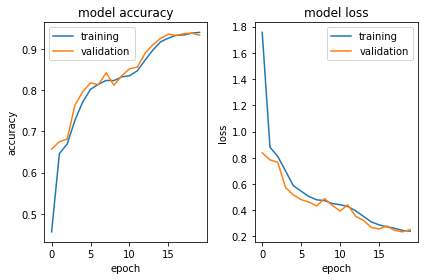

Test loss: 0.252
Test accuracy: 0.936

dropout_rate: 0.1


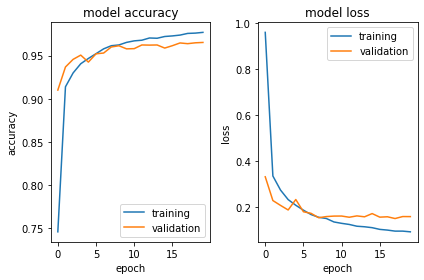

Test loss: 0.159
Test accuracy: 0.968


In [4]:
epochs = 20
batch_size = 32
validation_split = 0.2

dropout_rates = [.8, .5, .3, .2, .1]

for dropout_rate in dropout_rates:
    model = model_with_dropout(dropout_rate)
    model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(mnist_training_data, mnist_training_labels, batch_size=batch_size, epochs=epochs, verbose=False, validation_split=validation_split)
    print(f'\ndropout_rate: {dropout_rate}')
    plot_training_history(history, model)

In [5]:
# As you can see, using different rates can seriously impact performance.
# With very high rates, our networks have not converged, and results are 
# unstable. At lower rates, training accuracy stays below validation acc.
# and thats good. 

# It's also worth considering dropout only at specific layers
# not just at every layer. The complexity that builds up near
# the end of a network holds a greater risk of contributing to 
# overfitting. Experiment with that too:
def model_with_selective_dropout(dropout_rate, dropout_layers):
    assert dropout_layers <= 5
    
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(mnist_image_size,)))
    
    no_drop_layers = 5 - dropout_layers
    for _ in range(no_drop_layers):
        model.add(Dense(units=64, activation='relu'))
        
    for _ in range(dropout_layers):
        model.add(Dense(units=64, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=mnist_num_classes, activation='softmax'))
    
    return model



dropout_rate: 0.3 dropout_layers=3


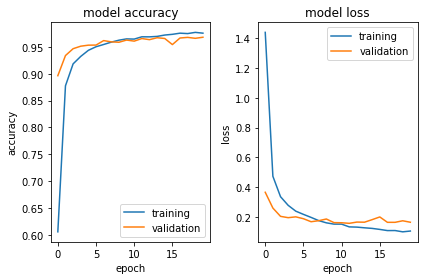

Test loss: 0.183
Test accuracy: 0.966

dropout_rate: 0.3 dropout_layers=2


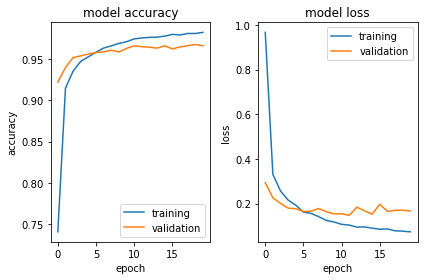

Test loss: 0.171
Test accuracy: 0.968

dropout_rate: 0.3 dropout_layers=1


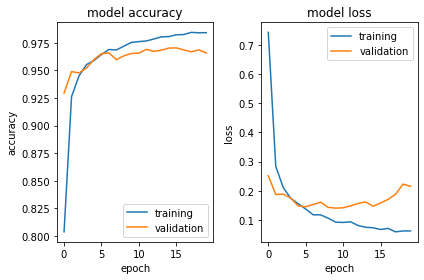

Test loss: 0.216
Test accuracy: 0.968

dropout_rate: 0.2 dropout_layers=3


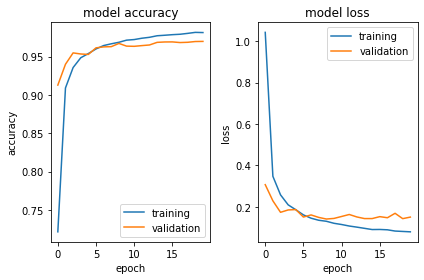

Test loss: 0.173
Test accuracy: 0.968

dropout_rate: 0.2 dropout_layers=2


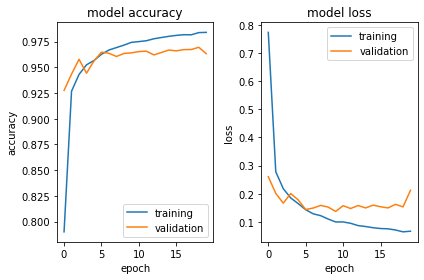

Test loss: 0.236
Test accuracy: 0.966

dropout_rate: 0.2 dropout_layers=1


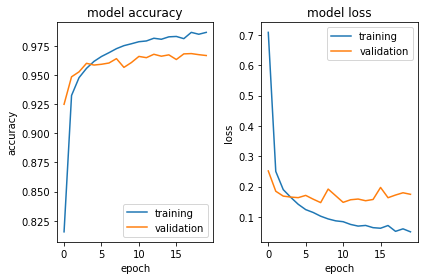

Test loss: 0.17
Test accuracy: 0.97

dropout_rate: 0.1 dropout_layers=3


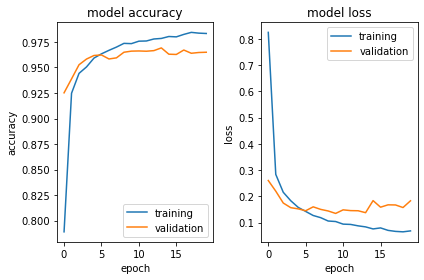

Test loss: 0.178
Test accuracy: 0.965

dropout_rate: 0.1 dropout_layers=2


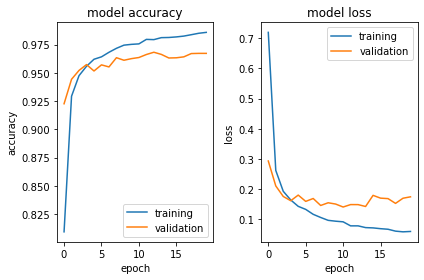

Test loss: 0.165
Test accuracy: 0.969

dropout_rate: 0.1 dropout_layers=1


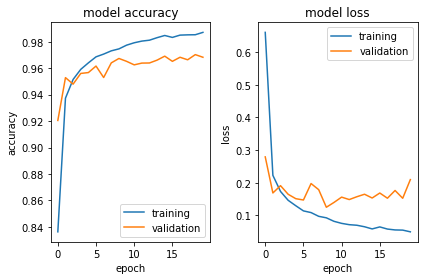

Test loss: 0.185
Test accuracy: 0.971


In [6]:
from itertools import product

epochs = 20
batch_size = 32
validation_split = 0.2

# Note, we didn't get far with .8 or .5, so I removed them for this experiment
# However, in larger networks .8 and .5 may be reasonable choices! Don't over
# generalize the findings that might be specific to this network architecture 
# and this dataset!
dropout_rates = [.3, .2, .1]
dropout_layers = [3, 2, 1]

for dropout_rate, dropout_layers in product(dropout_rates, dropout_layers):
    model = model_with_selective_dropout(dropout_rate, dropout_layers)
    model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(mnist_training_data, mnist_training_labels, batch_size=batch_size, epochs=epochs, verbose=False, validation_split=validation_split)
    print(f'\ndropout_rate: {dropout_rate} dropout_layers={dropout_layers}')
    plot_training_history(history, model)

The differences between these networrs is mostly at the margins, and dropping out on the last layer only seemed to do well—but it does appear that our models start to overfit slightly more with only dropout on the last layer. Lets see if we can tease that out by training for longer:

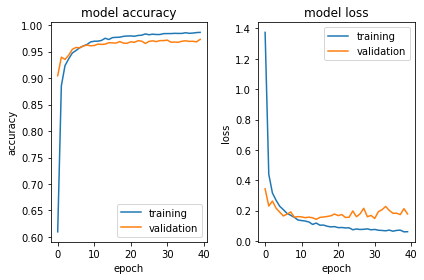

Test loss: 0.229
Test accuracy: 0.973


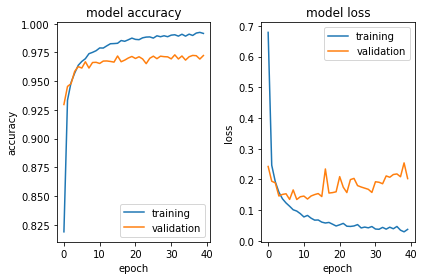

Test loss: 0.19
Test accuracy: 0.975


In [7]:
# This configuration has the most total dropout, most layers and highest percent
# We're giving it 40 epochs now. We hope performance gets a little better!
model = model_with_selective_dropout(0.3, 3) 
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(mnist_training_data, mnist_training_labels, batch_size=batch_size, epochs=40, verbose=False, validation_split=validation_split)
plot_training_history(history, model)

# This model peformed the best on test after 20 epochs, 
# but validation was worse than training after about 5 epochs
# At 40 epochs, we want to see if it starts to overfit too much even with dropout
model = model_with_selective_dropout(0.1, 2)
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(mnist_training_data, mnist_training_labels, batch_size=batch_size, epochs=40, verbose=False, validation_split=validation_split)
plot_training_history(history, model)

It's worth noting how much more stable the network with more dropout was, even though its test performance was worse. But, both of those saw their performance degrade by adding more training rounds! That's a good seguay into the next topic.

## Early Stopping

Early stopping is a tactic used in lots of ML models, not just neural networks. As the name suggests, early stopping prevents a model from overfitting by stopping training earlier than specified. Typically, early stopping is tied to a metric (or metrics) like validation loss or validation accuracy—if scores on a validation metric stop improving (or get worse) while training scores continue to rise, we're probably overfitting and we should stop training. 

There are caveats here, scores can go down in one epoch, then go back up in the next epoch for example. To accomodate this Keras provides a both a `patience` parameter which allows us to specify how many epochs in a row training must not improve before we stop early. Keras also provides as well as a `restore_best_weights` parameter, which allows the network to revert to the best weights found. Say we have `patience=2`, and performance decreases for 2 consecutive rounds, Keras could rever the weights for our model to whatever they were before those two rounds of degrading performance. 

This has an added benefit of reducing training time in many cases.

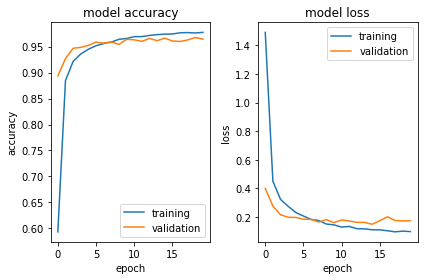

Test loss: 0.153
Test accuracy: 0.967


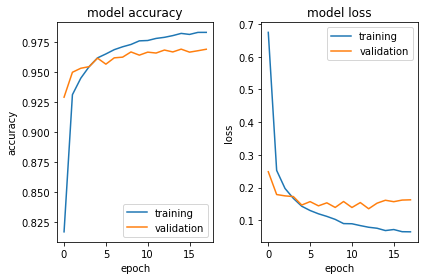

Test loss: 0.138
Test accuracy: 0.967


In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# There are lots of parameters you can set here, including the amount that counts as a change
# what metric to watch, and more. See the documentation for more details. We'll keep it
# simple for now, and use the defaults for most of these. 
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Now, lets repeat the same experiment we just did, but with early stopping!
model = model_with_selective_dropout(0.3, 3) 
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(mnist_training_data,
                    mnist_training_labels,
                    batch_size=batch_size,
                    epochs=40,
                    verbose=False,
                    validation_split=validation_split,
                    callbacks=[early_stopper])

plot_training_history(history, model)

# And the second model...
model = model_with_selective_dropout(0.1, 2)
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(mnist_training_data,
                    mnist_training_labels,
                    batch_size=batch_size,
                    epochs=40,
                    verbose=False,
                    validation_split=validation_split,
                    callbacks=[early_stopper])

plot_training_history(history, model)


As you can see, our test results are essentially the same in both cases, and we saved computational resoures.

It is worth noting, we have abused the notion of "test data" in this exercise: we're looking at test data for every model we train, making that data (more or less) validation data. If we looked only at the validation & training accuracy/loss curves, we would have good reason to prefer these bottom two situations due to their more stable performance, and lower divergence between training and validation scores. 